In [226]:
import pandas as pd
import os.path

data = pd.read_csv(os.getcwd() + '/steam_games.csv')
print(len(data))


40750


In [227]:
# Remove all invalid games, non english games, and non games
data = data[data['name'].str.contains('', na=False)] 
data = data[data['types'].str.contains('app')]
data = data[data['languages'].str.contains('English', na=False)]

# Replace all null genres and tags with 'Other'
data['genre'] = data['genre'].fillna('Other')
data['popular_tags'] = data['popular_tags'].fillna('Other')
data['game_details'] = data['game_details'].fillna('Other')

# Replace all no review games with 'Mixed'
data['all_reviews'] = data['all_reviews'].fillna('Mixed')

# Change reviews from strings to numerical values
def check_tuple(tuple_value):
    if 'overhwelmingly positive' in tuple_value.lower():
        return 4
    elif 'very positive' in tuple_value.lower():
        return 3
    elif 'mostly positive' in tuple_value.lower():
        return 1
    elif 'mixed' in tuple_value.lower():
        return 0
    elif 'overwhelmingly negative' in tuple_value.lower():
        return -4
    elif 'very negative' in tuple_value.lower():
        return -3
    elif 'mostly negative' in tuple_value.lower():
        return -1
    elif 'negative' in tuple_value.lower():
        return -2
    elif 'positive' in tuple_value.lower():
        return 2
    else:
        return 0
      
def check_tuple2(tuple_value):
    if 'overhwelmingly positive' in tuple_value.lower():
        return 'Overhwelmingly Positive'
    elif 'very positive' in tuple_value.lower():
        return 'Very Positive'
    elif 'mostly positive' in tuple_value.lower():
        return 'Mostly Positive'
    elif 'mixed' in tuple_value.lower():
        return 'Mixed'
    elif 'overwhelmingly negative' in tuple_value.lower():
        return 'Overwhelmingly Negative'
    elif 'very negative' in tuple_value.lower():
        return 'Very Negative'
    elif 'mostly negative' in tuple_value.lower():
        return 'Mostly Negative'
    elif 'negative' in tuple_value.lower():
        return 'Negative'
    elif 'positive' in tuple_value.lower():
        return 'Positive'
    else:
        return 'No Data'
      
data['review_scores'] = data['all_reviews']
data['review_scores'] = data['review_scores'].apply(check_tuple)
data['all_reviews'] = data['all_reviews'].apply(check_tuple2)

# Remove 12 irrelevant features to the training set 
data.drop(['url', 'types', 'recent_reviews', 'achievements', 'original_price', 'recommended_requirements', 'discount_price', 'minimum_requirements', 'mature_content', 'game_description',
           'release_date', 'languages'], axis=1, inplace=True)

col_list = data.columns.tolist()

for i in col_list:
  data[i] = data[i].fillna('')
  if isinstance(data[i], str):
  	data[i] = data[i].str.lower()
  	data[i] = data[i].str.replace('[^\w\s]','')
  # else:
  	# data[i] = data[i].astype(str).lower()
  	# data[i] = data[i].astype(str).replace('[^\w\s]','')	

print(len(data))
list(data.columns)

38003


['name',
 'desc_snippet',
 'all_reviews',
 'developer',
 'publisher',
 'popular_tags',
 'game_details',
 'genre',
 'review_scores']

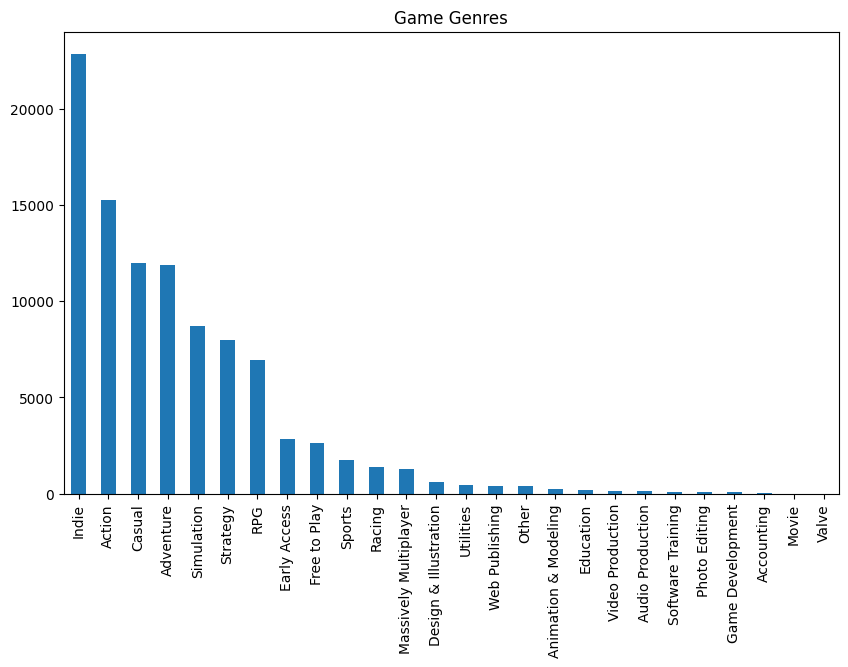

In [228]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

map_df = data.copy()

map_df['genre'] = map_df['genre'].str.split(',')
data_exploded = map_df.explode('genre')
counts = data_exploded['genre'].value_counts()

# Create a pie chart
ax = counts.plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Game Genres')
plt.show()

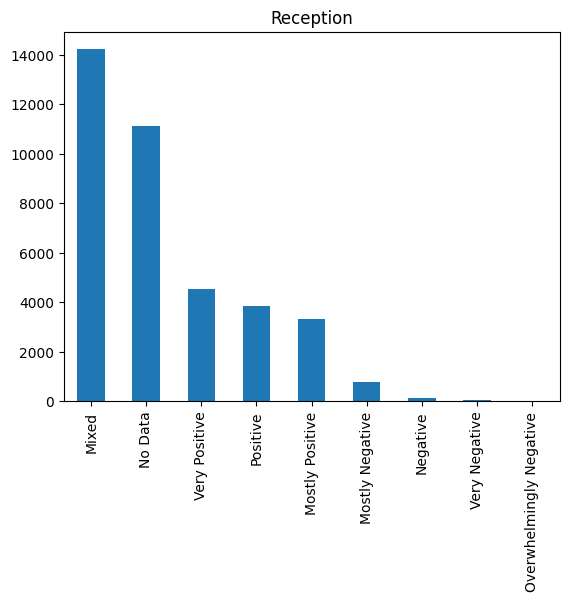

In [229]:

# Create a pie chart
ax = data['all_reviews'].value_counts().plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Reception')
plt.show()

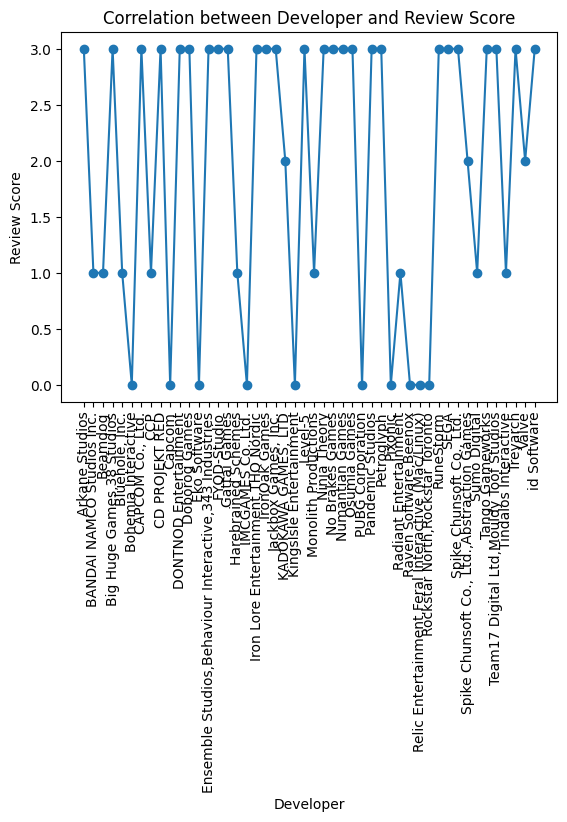

<Figure size 1000x600 with 0 Axes>

In [230]:
gf = data.head(50)
grouped_df = gf[['developer', 'review_scores']].groupby('developer').mean()

plt.plot(grouped_df.index, grouped_df['review_scores'], marker='o')
plt.xlabel('Developer')
plt.xticks(rotation = 90)
plt.ylabel('Review Score')
plt.title('Correlation between Developer and Review Score')
plt.figure(figsize=(10,6))

plt.show()

In [237]:
# the model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

df = data.head(100)

# df['desc_snippet'] = df['desc_snippet'].fillna('')
# df['desc_snippet'] = df['desc_snippet'].str.lower()
# df['desc_snippet'] = df['desc_snippet'].str.replace('[^\w\s]','')

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['desc_snippet'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# evaluate the model
indices = pd.Series(df.index, index=df['name'])
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    item_indices = [i[0] for i in sim_scores]
    return df['name'].iloc[item_indices]

# make recommendations
get_recommendations('Street Fighter V')

64                                 Northgard
30             Tree of Savior (English Ver.)
101                                Frostpunk
56             The Lord of the Rings Online™
33                                  Yakuza 0
52                       RUNNING WITH RIFLES
100                  DRAGON BALL XENOVERSE 2
94      Shadow Tactics: Blades of the Shogun
59     Grand Theft Auto IV: Complete Edition
17                               GOD EATER 3
Name: name, dtype: object

In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

df = data.head(10000).copy()

df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.replace('[^\w\s]','')

# select a game to use as input
input_game = 'DOOM'.lower()
result = df[df['name'] == 'DOOM']

print(result['name'])
# input_game = ' '.join([result['name'], result['desc_snippet'], result['developer'], result['publisher'], result['popular_tags'], result['genre']])

print(input_game)
strings = [' '.join(str(x) for x in row) for row in input_game]

concatenated_string = ' '.join(strings)
print(concatenated_string)

# feature extraction
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
df['features'] = df.apply(lambda x: ' '.join([x['name'], x['desc_snippet'], x['developer'], x['publisher'], x['popular_tags'], x['genre']]), axis=1)
tfidf_matrix = tfidf.fit_transform(df['features'])

# # build the model
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# # evaluate the model
indices = pd.Series(df.index, index=df['name'])
idx = indices[input_game]
sim_scores = list(enumerate(cosine_similarities[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:11]
game_indices = [i[0] for i in sim_scores]
recommendations = data['name'].iloc[game_indices].tolist()

print("Recommendations for", input_game)
print("---------------------------")
for game in recommendations:
    print(game)

C:\Users\Lemond Wyatt\AppData\Local\Temp\ipykernel_32296\4097649057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df['name'].str.lower()
C:\Users\Lemond Wyatt\AppData\Local\Temp\ipykernel_32296\4097649057.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['name'] = df['name'].str.replace('[^\w\s]','')
C:\Users\Lemond Wyatt\AppData\Local\Temp\ipykernel_32296\4097649057.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['name'] = df[

Series([], Name: name, dtype: object)
doom
d o o m
Recommendations for doom
---------------------------
Rage: The Scorchers™
Quake IV
Doom 3: BFG Edition
The Evil Within: The Executioner
DOOM Eternal
Fallout 3 - Broken Steel
Fallout 4 Far Harbor
RAGE
Fallout New Vegas: Courier's Stash
Fallout New Vegas: Honest Hearts
